In [174]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import config

In [2]:
%store -r sf_results_csv_fp
%store -r bq_results_csv_fp
%store -r results_dir

In [20]:
%store -r df_sf_history_sq
%store -r df_sf_history_av
%store -r df_bq_history

In [5]:
dfsf = pd.read_csv(sf_results_csv_fp)
dfbq = pd.read_csv(bq_results_csv_fp)

In [25]:
def row_extract_sf(row, value):
    """Extract Arbitrary row value from
    Snowflake Account Usage table
    
    Parameters
    ----------
    row : Pandas Series, from Snowflake history account view
    value : str, name of column in row
    
    Returns
    -------
    single value or None if nothing found
    """
    mask = df_sf_history_av.QUERY_ID == row["qid"]
    out = df_sf_history_av.loc[mask, value]
    if out.values.shape == (1,):
        return out.values[0]
    else:
        return None

In [32]:
def row_extract_bq(row, value):
    """Extract Arbitrary row value from
    BigQuery Account Usage table
    
    Parameters
    ----------
    row : Pandas Series, from BigQuery history account view
    value : str, name of column in row
    
    Returns
    -------
    single value or None if nothing found
    """
    mask = df_bq_history.job_id == row["qid"]
    out = df_bq_history.loc[mask, value]
    if out.values.shape == (1,):
        return out.values[0]
    else:
        return None

In [45]:
def bytes_to_TebiByte(b):
    return b / 1099511627776

#### Snowflake

In [11]:
sf_keep = ["QUERY_ID", "QUERY_TEXT", "DATABASE_NAME", "WAREHOUSE_SIZE", "WAREHOUSE_TYPE",
             "QUERY_TAG", "START_TIME", "END_TIME", "TOTAL_ELAPSED_TIME", "BYTES_SCANNED",
             "CREDITS_USED_CLOUD_SERVICES"]

In [12]:
sf_extended_keep = sf_keep + ["PERCENTAGE_SCANNED_FROM_CACHE", 
                             "PARTITIONS_SCANNED", "PARTITIONS_TOTAL", 
                             "BYTES_SPILLED_TO_LOCAL_STORAGE", "BYTES_SPILLED_TO_REMOTE_STORAGE"]

In [13]:
for col in sf_extended_keep:
    dfsf[col.lower()] = None
    
for col in sf_extended_keep:
    dfsf[col.lower()] = dfsf.apply(lambda x: row_extract(row=x, value=col), axis=1)

In [51]:
def to_int(x):
    try:
        return int(x)
    except:
        return None

In [63]:
def bytes_to_TebiByte(b):
    if pd.isnull(b):
        return None
    else:
        return b / 1099511627776

In [86]:
def bytes_to_TeraByte(b):
    if pd.isnull(b):
        return None
    else:
        return float(b) / 1e12

In [87]:
def TebiBytes_to_dollars(tib):
    if pd.isnull(tib):
        return None
    else:
        return tib * 5.00

Calculating Costs  
https://www.snowflake.com/blog/how-usage-based-pricing-delivers-a-budget-friendly-cloud-data-warehouse/
https://www.snowflake.com/pricing/



In [88]:
dfsf["dt"] = dfsf.end_time - dfsf.start_time
dfsf["dt_s"] = dfsf.dt.dt.total_seconds()
dfsf["Tib"] = dfsf.bytes_scanned.apply(to_int)
dfsf["TB"] = dfsf.bytes_scanned.apply(bytes_to_TeraByte)

In [89]:
# on demand billing
dfsf["cost_store_od"] = (dfsf.scale / 1000) * 40

dfsf["cost_comp_od_std"] = dfsf.credits_used_cloud_services * 2
dfsf["cost_comp_od_ent"] = dfsf.credits_used_cloud_services * 3
dfsf["cost_comp_od_bus"] = dfsf.credits_used_cloud_services * 4

#### BigQuery

In [90]:
bq_keep = ["statement_type", "start_time", "end_time", "total_bytes_processed", 
           "total_slot_ms",  "cache_hit", "labels"]

In [91]:
for col in bq_keep:
    dfbq[col.lower()] = None
    
for col in bq_keep:
    dfbq[col.lower()] = dfbq.apply(lambda x: row_extract_bq(row=x, value=col), axis=1)

In [92]:
dfbq["dt"] = dfbq.end_time - dfbq.start_time
dfbq["dt_s"] = dfbq.dt.dt.total_seconds()
dfbq["Tib"] = dfbq.total_bytes_processed.apply(bytes_to_TebiByte)
dfbq["TB"] = dfbq.total_bytes_processed.apply(bytes_to_TeraByte)

Calculating Costs  
https://cloud.google.com/bigquery/pricing  


In [93]:
dfbq["cost_comp"] = dfbq.TB * 5.00

#### Combine

In [148]:
common = ["db", "test", "scale", "source", "cid", "desc", "query_n", "seq_id", "dt", "dt_s", "TB"]

In [153]:
dfsf_short = dfsf[common] # + ["percentage_scanned_from_cache"]]

In [154]:
dfbq_short = dfbq[common]

In [157]:
df = pd.concat([dfsf_short, dfbq_short])

In [158]:
df = df[df.query_n != 61]

In [165]:
dfp_dt = df.pivot(index="query_n", columns="db", values="dt_s")
dfp_bp = df.pivot(index="query_n", columns="db", values="TB")

### Plot Results

In [175]:
sns.set_style("darkgrid", {"xtick.bottom":True})

In [176]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set2 = sns.color_palette("Set2", 8)
hls = sns.hls_palette(n_colors=12)

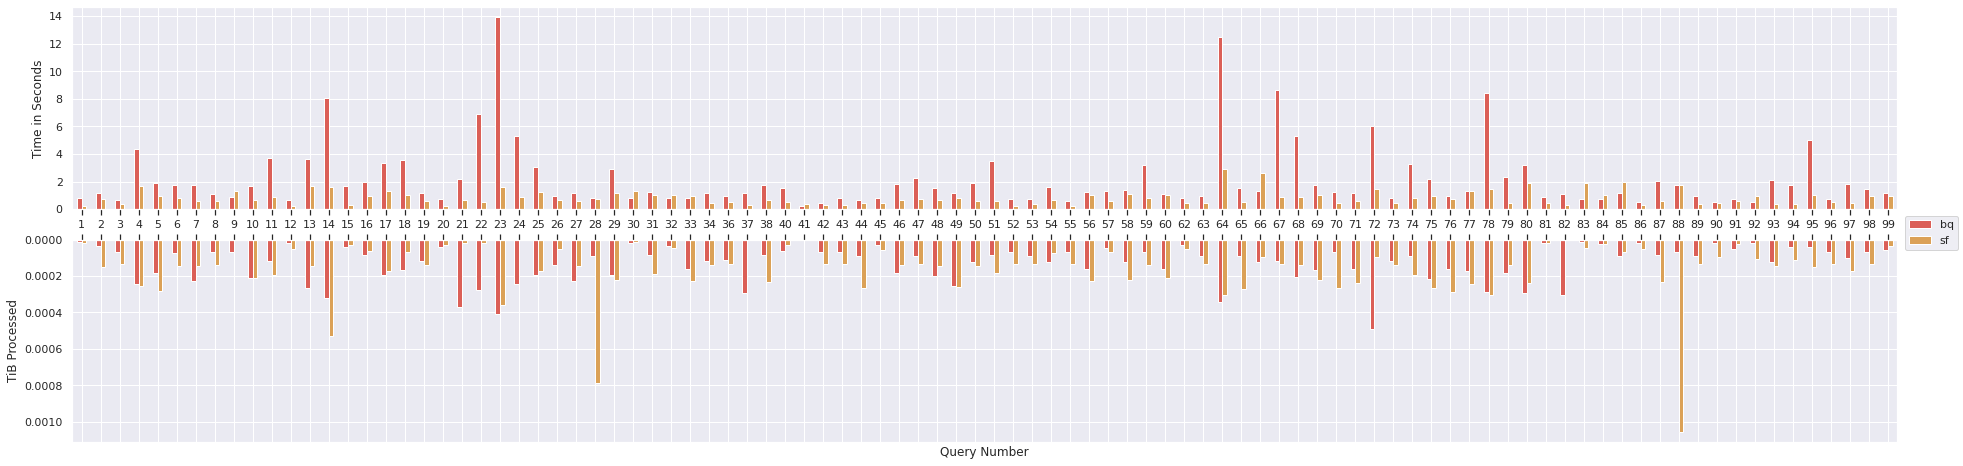

In [196]:
#plot_name = "{}_{}GB_{}_comparison.png".format(test, scale_factor, x_type)
plot_name = "Test Bar"

color_palette = hls
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1 = dfp_dt.plot.bar(ax=ax1, legend=False, color=color_palette)

# invert bytes processed for plotting
_dfp_bp = dfp_bp.copy() * -1
ax2 = _dfp_bp.plot.bar(ax=ax2, legend=False, color=color_palette);

# set the figure size BEFORE adjusting ticks
fig.set_size_inches(30, 8, forward=True)

handles, labels = ax1.get_legend_handles_labels()

ax1.set_ylabel("Time in Seconds")
ax1.set_xlabel(None)
ax1_xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels(labels=[])

ax2.set_ylabel("TiB Processed")
ax2.set_xlabel("Query Number")
ticks =  ax2.get_yticks()
ticks = ["{:01.4f}".format(abs(tick)) for tick in ticks]
ax2.set_yticklabels(ticks);
ax2.xaxis.tick_top()

plt.subplots_adjust(hspace=0.15)
plt.subplots_adjust(right=0.97)

fig.legend(handles, labels, loc="right")
#fig.legend(handles, labels, loc="lower center")
plt.savefig(config.fp_plots + config.sep + plot_name, bbox_to_anchor='tight')
print();